# DQN for navigation 

A DQN using Unity ML-Agents environment and pytorch

## Import and set environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn # neural networks 
import torch.optim as optim #optimization
import torch.nn.functional as F #convolution functions

import random
from collections import namedtuple, deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# set params
SEED = 1 # replicability randomization seed
BUFFER_SIZE = int(1e5) #replay buffer size
BATCH_SIZE = 64 # training batch size
GAMMA = 0.99 # discount factor
TAU = 2e-3 # target parameters update
ALPHA = 1e-3 # learning rate
UPDATE_RATE = 4 # update frequency

MAX_EPISODES=3000 
TIME_STEPS=1000
INIT_EPSILON=1.0
MIN_EPSILON=0.01
EPSILON_DECAY=0.995


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## DQN agents

In [6]:
## memory replay
class ReplayMemory():
    '''
    The class stores the transitions that the agent observes- 
     so we can use it later.
     
    The goal of the memory replay is to overcome a few issues with naive DQN.
    First, it reduces the high correlation between action and states, 
        which results in an unstable and ineffective policy.
    Second, it increases the learning speed by using small batches.
    Lastly, it avoids "forgetting" by randomly reusing past transitions. 
        
    '''
    def __init__(self, buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, 
                 seed=SEED):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.observation = namedtuple("observation", 
                        field_names=["state", "action", "reward", "next_state", "done"])
 

    def add(self, state, action, reward, next_state, done):
        '''
        Add a new observation to the buffer
        '''
        observation = self.observation(state, action, reward, next_state, done)
        self.buffer.append(observation)
    
    def sample(self,):
        '''
        Randomly samples from the buffer
        The transitions are decorrelated since they are sampled randomly
        '''
        observations = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([obvs.state for obvs in observations if obvs is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([obvs.action for obvs in observations if obvs is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([obvs.reward for obvs in observations if obvs is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([obvs.next_state for obvs in observations if obvs is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([obvs.done for obvs in observations if obvs is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        '''Return the current size of internal memory.'''
        return len(self.buffer)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQN_Agent():
    '''
    DQN- Deep Q-learning Network is a deep neural network 
        that acts as a function approximator.
        
    '''
    def __init__(self, env,
                 replay_memory_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, 
                 gamma=GAMMA, alpha=ALPHA, target_tau=TAU,
                 max_episodes=MAX_EPISODES,time_steps=TIME_STEPS,
                 init_eps=INIT_EPSILON, min_eps=MIN_EPSILON, eps_decay=EPSILON_DECAY,
                 update_rate=UPDATE_RATE, seed=SEED):
        
        #get the env and reset it
        self.env = env 
        brain_name = self.env.brain_names[0]
        brain = self.env.brains[brain_name]
        self.env.reset(train_mode=True)[brain_name]
        
        self.action_size = brain.vector_action_space_size # N actions
        self.state_size = len(env_info.vector_observations[0]) #N states
        
        self.buffer_size = int(replay_memory_size) 
        self.batch_size = batch_size
        
        # Network hyperparameters 
        self.gamma = gamma # discount factor
        self.tau = target_tau # target network parameters update
        
        self.update_rate = update_rate #update when step%update_rate==0
        self.seed = random.seed(seed) #randomization for replicability
        
        # Q-Network
        self.qnetwork_local = self.QNetwork().to(device)
        self.qnetwork_target = self.QNetwork().to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)
        
        # Replay memory
        self.memory = ReplayMemory(replay_memory_size, batch_size, seed)
        self.t_step = 0 #time step init
        
        #training params
        self.max_episodes = max_episodes #max training episodes
        self.time_steps = time_steps #timesteps per episode
        self.init_eps = init_eps #initial epsilon for gteedy epsilon action choice
        self.min_eps = min_eps #smallest possible greedy
        self.eps_decay = eps_decay #epsilon deacy along the episodes
        
    def QNetwork(self):
        '''
        build the q-learning network
        '''
        model = nn.Sequential(nn.Linear(self.state_size, 64),
                             nn.ReLU(),
                             nn.Linear(64, 64),
                             nn.ReLU(),
                             nn.Linear(64,self.action_size))
        return model

    def step(self, state, action, reward, next_state, done):
        '''add current observations to memory
        '''
        self.memory.add(state, action, reward, next_state, done)
        
        # update the network (given UPDATE_RATE)
        self.t_step = (self.t_step + 1) % self.update_rate
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                observations = self.memory.sample()
                self.policy_update(observations)
    
    def act(self, state, eps=0.):
        '''
        given current policy, returns action for the input state
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def policy_update(self, observations):
        """
        update policy using a randomly sampled batch of observations
        """
        states, actions, rewards, next_states, dones = observations

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        ## update target net
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        
        for target_param, local_param in zip(self.qnetwork_target.parameters(), 
                                             self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        
    def train(self):
        '''
        Train the DQN network
        '''
        scores = []
        eps = self.init_eps
        
        for episode in range(1, self.max_episodes+1):
            #set the env
            env_info = self.env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]         
            episode_score = 0
            
            # run each episode
            for _ in range(self.time_steps): 
                #act
                action = self.act(state, eps)
                env_info = env.step(action)[brain_name]
                next_state = env_info.vector_observations[0]
                reward = env_info.rewards[0]  
                done = env_info.local_done[0]
                #record
                self.step(state, action, reward, next_state, done)
                episode_score += reward
                state = next_state
                
                #exit if finished
                if done:                                     
                    break
            
            scores.append(episode_score)
            # decrease epsilon
            eps = max(self.min_eps, eps*self.eps_decay)
            if episode % 100 == 0:
                print('Episode: ',episode, 'Score: ',np.mean(scores[-100:]))
            if np.mean(scores[-100:])>=13.0:
                torch.save(self.qnetwork_local.state_dict(), 'checkpoint.pth')
                print('Episode: ',episode, 'Score: ',np.mean(scores[-100:]))

                break
        return scores

## Train agent

In [8]:
agent=DQN_Agent(env)
scores=agent.train()

Episode:  100 Score:  0.89
Episode:  200 Score:  4.44
Episode:  300 Score:  8.34
Episode:  400 Score:  9.79
Episode:  496 Score:  13.01


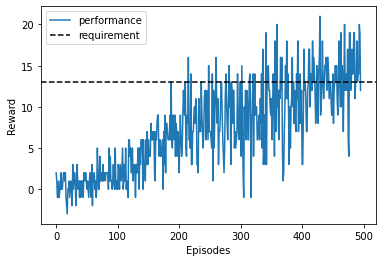

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='performance')
plt.ylabel('Reward')
plt.axhline(y=13, color='black', linestyle="--", label='requirement')
plt.xlabel('Episodes')
plt.legend()
plt.show()

In [23]:
torch.save(agent.qnetwork_target.state_dict(), 'model.')